# Location Charts

Shot charts are a valuable resource for those analyzing a player or team. They can reveal tendencies, strengths, or weaknesses in a plan of attack. The same can be said for assist charts.

The following explores the `Player` class of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `shortchartdetail` and `playerdashptpass` endpoints of the [stats.nba.com](https://stats.nba.com). The goal of this analysis is to build charts that visualize shooting and passing data.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

from PIL import Image
import time

from py_ball import player, playbyplay

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `shotchartdetail` endpoint accepts a variety of parameters, but only a few are relevant for shot probability purposes:
- league_id: '00' for the NBA, '10' for the WNBA
- player_id: The unique identifier for the player (0 returns shot data for the whole game)
- game_id: The unique identifier for the game of interest
- season: YYYY-ZZ season year format (This only affects the league averages returned)

In [22]:
league_id = '00' #NBA
player_id = '0' #All players
game_id = '0021800699'
season = '2018-19'

shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season)
shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
shot_df.head(15)

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Layup Shot,Missed Shot,20190121,7,0021800699,Shot Chart Detail,PHI,13,30,11,...,1,3,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612755,Philadelphia 76ers,HOU
1,Putback Dunk Shot,Missed Shot,20190121,9,0021800699,Shot Chart Detail,PHI,0,-6,11,...,1,0,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612755,Philadelphia 76ers,HOU
2,Jump Shot,Missed Shot,20190121,11,0021800699,Shot Chart Detail,PHI,-153,217,11,...,1,26,0,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612745,Houston Rockets,HOU
3,Tip Layup Shot,Missed Shot,20190121,13,0021800699,Shot Chart Detail,PHI,0,-6,11,...,1,0,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612745,Houston Rockets,HOU
4,Running Layup Shot,Made Shot,20190121,15,0021800699,Shot Chart Detail,PHI,14,24,11,...,1,2,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612755,Philadelphia 76ers,HOU
5,Jump Shot,Made Shot,20190121,17,0021800699,Shot Chart Detail,PHI,25,214,11,...,1,21,1,2PT Field Goal,Center(C),Mid-Range,16-24 ft.,1610612745,Houston Rockets,HOU
6,Putback Layup Shot,Missed Shot,20190121,30,0021800699,Shot Chart Detail,PHI,0,-6,10,...,1,0,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612755,Philadelphia 76ers,HOU
7,Layup Shot,Missed Shot,20190121,28,0021800699,Shot Chart Detail,PHI,-22,30,10,...,1,3,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612755,Philadelphia 76ers,HOU
8,Jump Shot,Missed Shot,20190121,33,0021800699,Shot Chart Detail,PHI,215,116,10,...,1,24,0,3PT Field Goal,Right Side Center(RC),Above the Break 3,24+ ft.,1610612755,Philadelphia 76ers,HOU
9,Jump Shot,Made Shot,20190121,36,0021800699,Shot Chart Detail,PHI,-98,10,10,...,1,9,1,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612755,Philadelphia 76ers,HOU


The above shows shot information from a Rockets at Sixers on 1/21/19. This game will serve as an example for generating player and team shot charts. First, we'll need a function to generate a court visual.

In [23]:
def draw_court():
    """ draw_court draws an NBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an NBA court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 90], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 90], 'k-') # 3pt straight

    three_point = Arc((0, 0), width=237.5*2, height=237.5*2, theta1=22, theta2=158, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

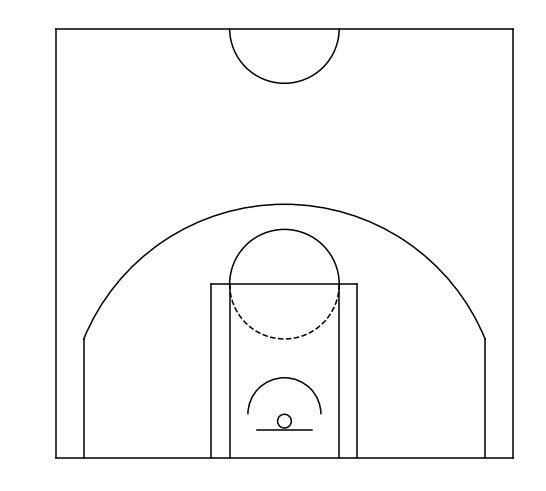

In [24]:
court, court_axis = draw_court()
court

With the court visualization, the next step is to write a function that plots shots for a given player or team.

In [54]:
def plot_shot(shot_df, player_or_team, unit_id):
    """ plot_shot plots a shot or list of shots given in the
    shot DataFrame provided

    @param shot_df (DataFrame): DataFrame of shots with LOC_X and
        LOC_Y columns

    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of shot chart to generate

    @param unit_id (int): Unique identifier of player or team

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the shots plotted
    """
    court, court_axis = draw_court()
    if player_or_team=='team':
        shot = shot_df[shot_df['TEAM_ID']==unit_id]
        court_axis.set_title(shot['TEAM_NAME'].iloc[0], fontsize=14)
    else:
        shot = shot_df[shot_df['PLAYER_ID']==unit_id]
        court_axis.set_title(shot['PLAYER_NAME'].iloc[0], fontsize=14)

    miss_df = shot[shot['SHOT_MADE_FLAG']==0]
    make_df = shot[shot['SHOT_MADE_FLAG']==1]

    if len(make_df)>0:
        court_axis.plot(-make_df['LOC_X'], make_df['LOC_Y'], 'ko', alpha=0.5, label='Make')
    if len(miss_df)>0:
        court_axis.plot(-miss_df['LOC_X'], miss_df['LOC_Y'], 'kx', alpha=0.5, label='Miss')

    plt.legend(loc='upper right')
    plt.close()
    return court

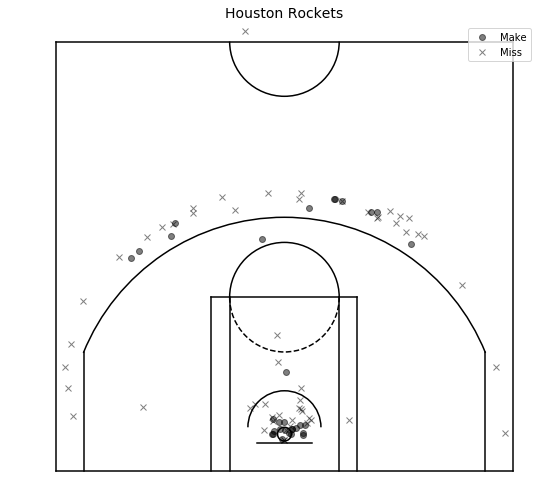

In [57]:
plot_shot(shot_df, 'team', 1610612745)

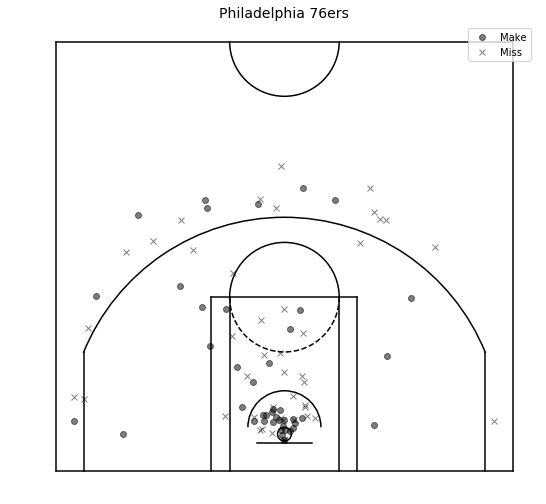

In [58]:
plot_shot(shot_df, 'team', 1610612755)

The Sixers controlled the game, winning 121-93. The Rockets played to their gameplan by nearly eliminating the midrange shot from their repertoire, but the Sixers were able to get to the rim with regularity.